In [22]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


In [2]:
# Read the CSV data into the pandas dataframe
file = '../data/data.csv'
data = pd.read_csv(file)

In [3]:
# Let's replace the label column values to 0 for normal and 1 for others!

LABELS = data["label"].unique() # Get Unique Values of label column
LABELS = [label for label in LABELS if label != "normal"] #All labels other than Normal!

data["label"].replace(['normal'], 0, inplace=True)
data["label"].replace(LABELS, 1 , inplace=True)


In [4]:
data = data.fillna("None") # fill all the empty hosts with 0

#Now let's encode all the columns which are not float or int e.g. sourceIP, MAC to make it possible for model to interpret
columnsToEncode = list(data.select_dtypes(include=['category', 'object']))  
            
le = LabelEncoder() # use label encoder from sklearn

for feature in columnsToEncode:
    try:
        data[feature] = le.fit_transform(data[feature])
        #print(data[feature])
    except:
        print ('error' + feature)


In [5]:
data.head()

,uid,sourceMac,sourceIp,destIp,destMac,sourcePort,destPort,host,kIn,kOut,...,outPacketsNo,protocol,urgent,ack,push,reset,syn,fin,timestamp,label
0,0,0,2,15,5,19357,8000,3,0.0,1.015625,...,2,17,0,0,0,0,0,0,22374,1
1,0,0,2,15,5,1939,8000,3,0.0,1.015625,...,2,17,0,0,0,0,0,0,22374,1
2,0,0,2,15,5,19668,8000,3,0.0,0.507813,...,1,17,0,0,0,0,0,0,22374,1
3,0,0,2,15,5,19807,8000,3,0.0,0.507813,...,1,17,0,0,0,0,0,0,22374,1
4,0,0,2,15,5,19851,8000,3,0.0,0.507813,...,1,17,0,0,0,0,0,0,22374,1


In [6]:
data["label"].value_counts()

1    2988506
0      91386
Name: label, dtype: int64

In [7]:
Train, Val = sklearn.model_selection.train_test_split(data, test_size=0.9, random_state=1, shuffle=True)

In [8]:
Train["label"].value_counts()

1    298792
0      9197
Name: label, dtype: int64

In [9]:
Val["label"].value_counts()

1    2689714
0      82189
Name: label, dtype: int64

In [10]:
Attack = Train[Train['label']==1]
Normal = Train[Train['label']==0]
outlier_fraction = np.ceil(len(Attack)/float(len(Normal)))

#Let's print how many more outliers are there in the dataset compared to normal data
print(outlier_fraction)

33.0


In [35]:
#Let's now split the features and the target ground truth
features = [feature for feature in Train.columns.tolist() if feature not in ["label"]]
target = "label"

# Define a random state 
state = np.random.RandomState(42)
X_train = Train[features]
Y_train = Train[target]

X_val = Val[features]
Y_val = Val[target]

X_outliers = state.uniform(low=0, high=1, size=(X_train.shape[0], X_train.shape[1]))
# Print the shapes of X & Y
print(X_train.shape)
print(Y_train.shape)

(307989, 20)
(307989,)


In [13]:
#Let's initalize some classifiers
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train), 
                                       contamination=outlier_fraction,random_state=state, verbose=1),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.03),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1 )
   
}

In [ ]:
n_outliers = len(Attack)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))


Local Outlier Factor: 291532
Accuracy Score :
0.053433726529194224
Classification Report :
              precision    recall  f1-score   support

           0       0.03      0.89      0.05      9197
           1       0.89      0.03      0.05    298792

    accuracy                           0.05    307989
   macro avg       0.46      0.46      0.05    307989
weighted avg       0.87      0.05      0.05    307989



In [ ]:
n_outliers = len(Attack)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))


In [12]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

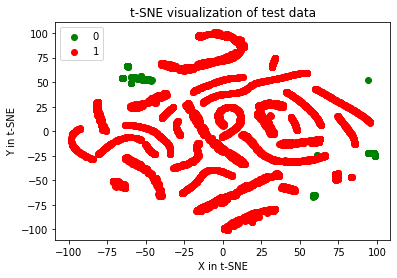

In [25]:
def tsne_plot(x1, y1, name="graph.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE visualization of test data')
    plt.show()
    
tsne_plot(X_train[:8000], Y_train[:8000])


In [27]:
#I think training this kind of dataset with autoencoders makes more sense so let's try that

## input layer 
input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [28]:
#Compile the mdoel
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [29]:
#let's do bit of data transformation for scaling

x = X_train
y = Y_train

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [30]:
autoencoder.fit(x_norm[0:8000], x_norm[0:8000], 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.1274 - val_loss: 0.1273
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.1270 - val_loss: 0.1269
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 0.1266 - val_loss: 0.1264
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.1261 - val_loss: 0.1259
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.1255 - val_loss: 0.1253
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.1249 - val_loss: 0.1247
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.1243 - val_loss: 0.1240
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.1236 - val_loss: 0.1234
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 0.1230 - val_loss: 0.1228
Epoch 10/50
25/25 [==============================] - 0s 11ms/step - loss: 0.1223 - val_loss: 0.1221
Epoch 11/50
25/25 

In [31]:
#Let's try tp get latent learnt representation by autoencoder
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [32]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud[:3000])


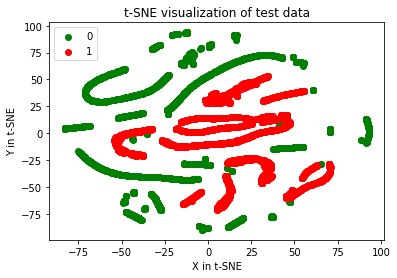

In [33]:
#Let's try to visualize TSNE again for the learnt representation
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

tsne_plot(rep_x, rep_y)

In [34]:
#Finally we can train a classifier on learnt representations

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       783
         1.0       0.99      1.00      0.99       717

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500


Accuracy Score:  0.9946666666666667


In [37]:
#Finally we can train a classifier on learnt representations

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(X_train, Y_train)
pred_y = clf.predict(X_val)

print ("")
print ("Classification Report: ")
print (classification_report(Y_val, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(Y_val, pred_y))

/home/coding/MyProjects/Avira-AnomalyDetection/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     82189
           1       1.00      1.00      1.00   2689714

    accuracy                           1.00   2771903
   macro avg       1.00      0.99      1.00   2771903
weighted avg       1.00      1.00      1.00   2771903


Accuracy Score:  0.9996976806186941
